I was present during both classes - 09.06 and 16.06

In [1]:
install.packages('pesel')
devtools::install_github("psobczyk/varclust")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




iterators  (NA -> 1.0.14   ) [CRAN]
rngtools   (NA -> 1.5.2    ) [CRAN]
foreach    (NA -> 1.5.2    ) [CRAN]
doRNG      (NA -> 1.8.6.2  ) [CRAN]
doParallel (NA -> 1.0.17   ) [CRAN]
RcppEigen  (NA -> 0.3.4.0.2) [CRAN]


Installing 6 packages: iterators, rngtools, foreach, doRNG, doParallel, RcppEigen

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpNW8IAG/remotesd83105bc7e/psobczyk-varclust-c2b23b9/DESCRIPTION’ ... OK
* preparing ‘varclust’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘varclust_0.10.0.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



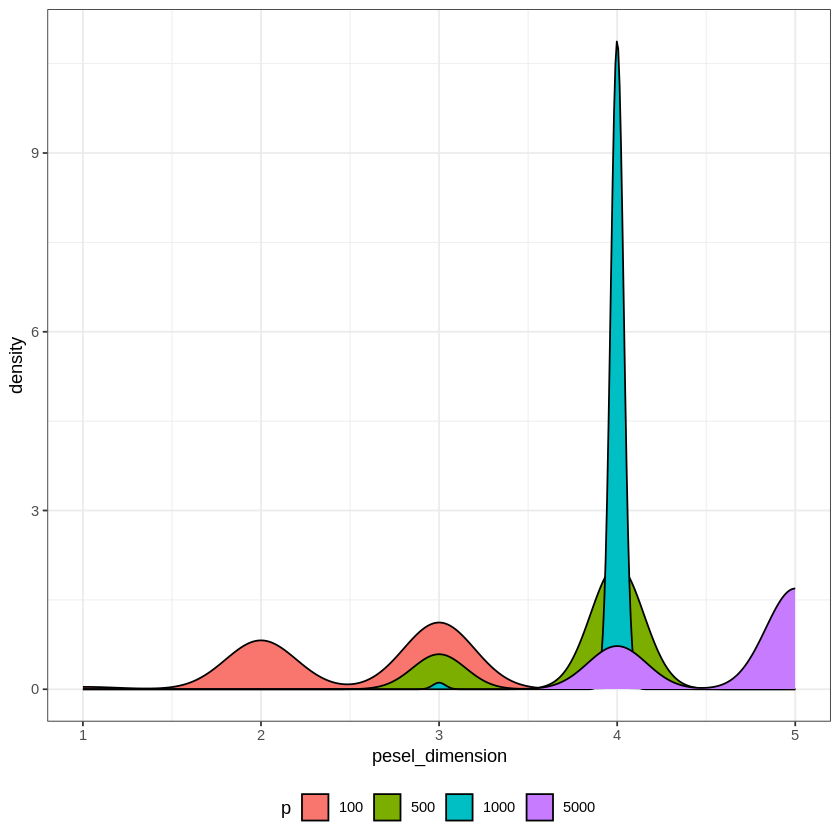

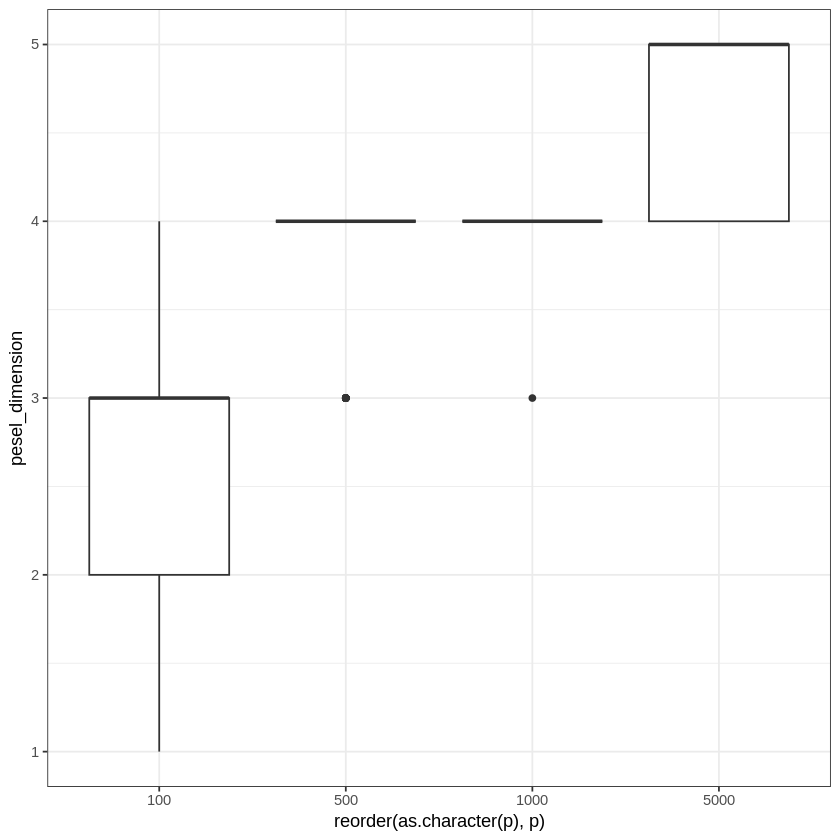

In [ ]:
library(pesel)
library(varclust)
library(data.table)
library(ggplot2)
library(parallel)

n = 50
ps = c(1e2, 5e2, 1e3, 5e3)
num_iter = 100

pesel_dimensions = rbindlist(lapply(ps, function(p) {
  rbindlist(mclapply(seq_len(num_iter), function(iter) {
    Fm = matrix(rnorm(n * 5, 0, 1), nrow = n)
    Wm = do.call("cbind", lapply(1:5, function(j) (6 - j) * rnorm(p, 0, 1)))
    Em = matrix(rnorm(n * p, 0, 10), nrow = n)
    X = Fm %*% t(Wm) + Em

    list(n = n,
         p = p,
         iter = iter,
         pesel_dimension = pesel(X)$nPCs)
  }, mc.cores = 2))
}))

ggplot(pesel_dimensions, aes(x = pesel_dimension, fill = reorder(as.character(p), p))) +
  geom_density() + # alpha = 0.5
  theme_bw() +
  scale_fill_discrete(name = "p") +
  theme(legend.position = "bottom")
ggplot(pesel_dimensions, aes(x = reorder(as.character(p), p), y = pesel_dimension)) +
  geom_boxplot() +
  theme_bw()

# TODO June 6/9: 2. a), c)
# TODO June: 13/16: 2. b), 3)

In [ ]:
n = 50
p = 800
K = 4

X_block = lapply(1:K, function(k) {
  Fm = matrix(rnorm(n * 3), nrow = n)
  Wm = do.call(cbind, lapply(1:3, function(j) (4 - j) * rnorm(200)))
  Em = matrix(rnorm(n * 200), nrow = n)
  X_result = Fm %*% t(Wm) + Em
  list(X = X_result)
})

X = do.call(cbind, lapply(X_block, function(b) b$X))


In [ ]:
pesel_result = pesel(X, npc.max = 20)
print(pesel_result)

$nPCs:  12 
$vals: value of PeSeL criterion
$prior: prior probabilities
$posterior: posterior probabilities
$npc.min:  0 
$npc.max:  20 


In [ ]:
pca_res = prcomp(X, center = TRUE, scale. = FALSE)
n_pcs = pesel_result$nPCs
loadings = pca_res$rotation[, 1:n_pcs]

top_loadings = apply(loadings, 2, function(x) order(abs(x), decreasing = TRUE)[1:10])

In [ ]:
top_loadings

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
429,112,702,215,705,705,600,158,300,530,179,322
502,4,429,289,213,352,490,15,322,509,189,189
401,31,750,312,614,213,491,173,305,529,59,609
464,50,799,429,694,223,501,31,282,551,60,327
513,52,628,398,613,356,546,68,289,542,58,685
526,101,721,302,112,348,519,163,217,586,82,632
112,65,502,205,721,267,561,138,303,513,57,289
799,21,758,352,783,614,419,80,361,477,122,771
750,185,464,251,687,721,511,112,302,532,119,57
504,213,401,228,665,229,446,113,284,500,198,748


In [ ]:
block_labels <- rep(1:K, each = 200)
block_table <- apply(top_loadings, 2, function(vars) table(block_labels[vars]))
print(block_table)

$PC1

1 3 4 
1 7 2 

$PC2

1 2 
9 1 

$PC3

3 4 
4 6 

$PC4

2 3 
9 1 

$PC5

1 2 4 
1 1 8 

$PC6

2 4 
7 3 

$PC7

 3 
10 

$PC8

 1 
10 

$PC9

 2 
10 

$PC10

 3 
10 

$PC11

 1 
10 

$PC12

1 2 4 
2 3 5 



In [ ]:
install.packages(c("dplyr", "tidyr", "ggplot2"))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("patchwork")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



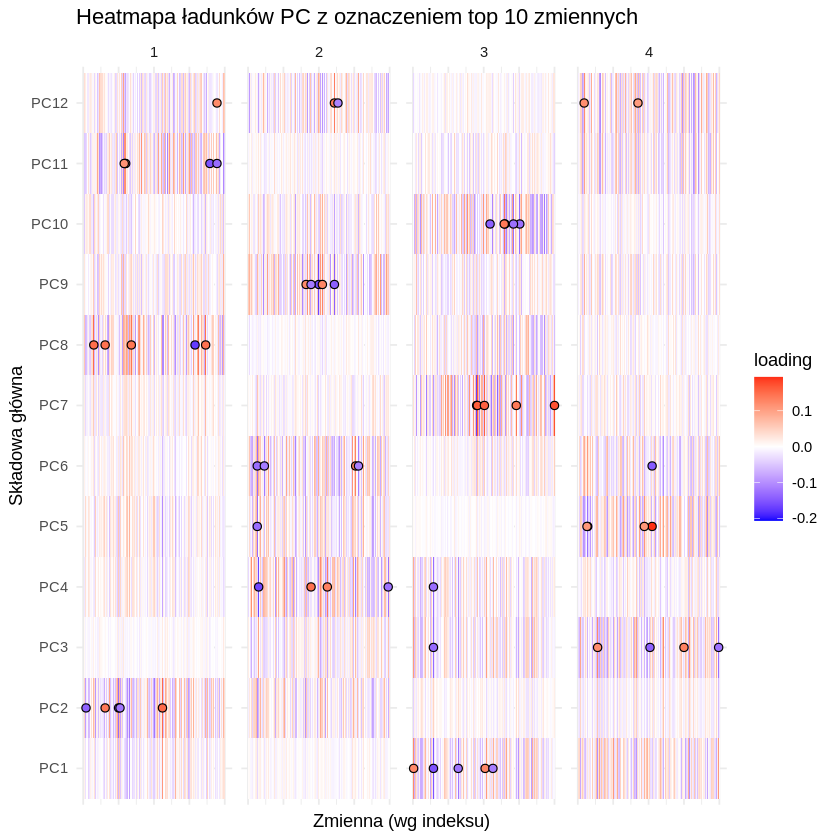

In [ ]:
library(ggplot2)
library(dplyr)
library(tidyr)

k <- pesel_result$nPCs
block_labels <- factor(rep(1:K, each = 200))

loadings_mat <- loadings[, 1:k]
loadings_df <- as.data.frame(loadings_mat)
loadings_df$variable <- 1:p
loadings_df$block <- block_labels

loadings_long <- loadings_df %>%
  pivot_longer(cols = starts_with("PC"),
               names_to = "PC",
               values_to = "loading")

loadings_long$PC <- factor(loadings_long$PC, levels = paste0("PC", 1:k))
loadings_long <- loadings_long %>% mutate(abs_loading = abs(loading))

top10 <- loadings_long %>%
  group_by(PC) %>%
  slice_max(abs_loading, n = 5)

ggplot(loadings_long, aes(x = variable, y = PC, fill = loading)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  geom_point(data = top10, aes(x = variable, y = PC), color = "black", size = 2, shape = 21) +
  facet_wrap(~block, scales = "free_x", nrow = 1) +
  labs(title = "Heatmapa ładunków PC z oznaczeniem top 10 zmiennych",
       x = "Zmienna (wg indeksu)",
       y = "Składowa główna") +
  theme_minimal() +
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank())


Number of clusters 	 BIC 
        1          -45936 
        2          -34692 
        3          -29388 
        4          -23571 
        5          -23819 


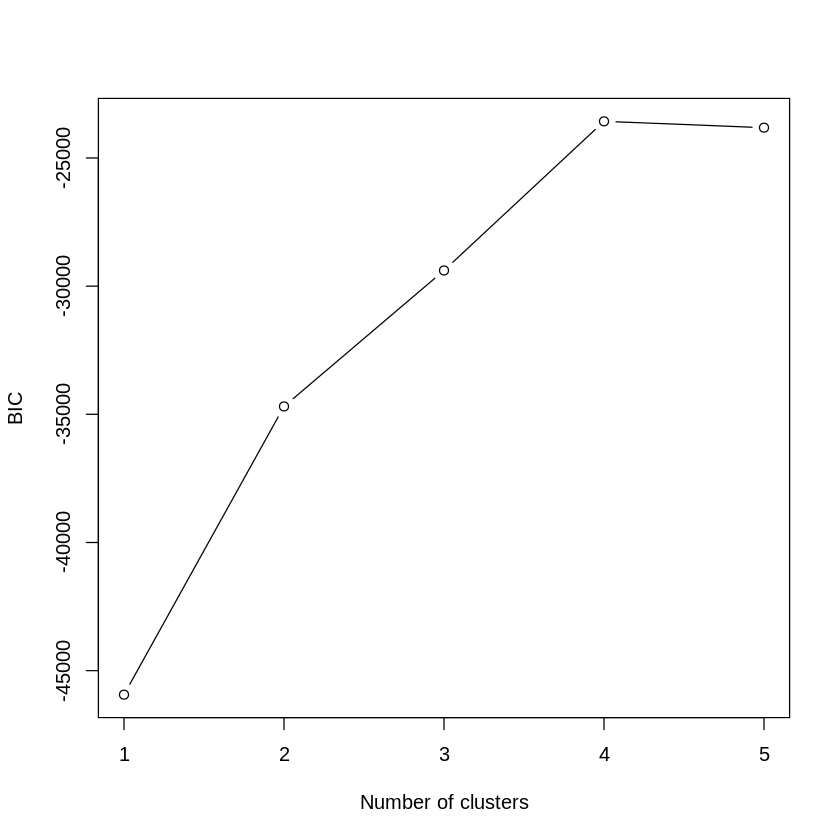

In [ ]:
varclust_res = mlcc.bic(X, numb.cores = 5, verbose=TRUE, max.iter=1, numb.runs=1,  numb.clusters = 1:10, show.warnings=TRUE)

Number of clusters 	 BIC 
        1          -45936 
        2          -38172 
        3          -29423 
        4          -24317 
        5          -24102 
        6          -24117 


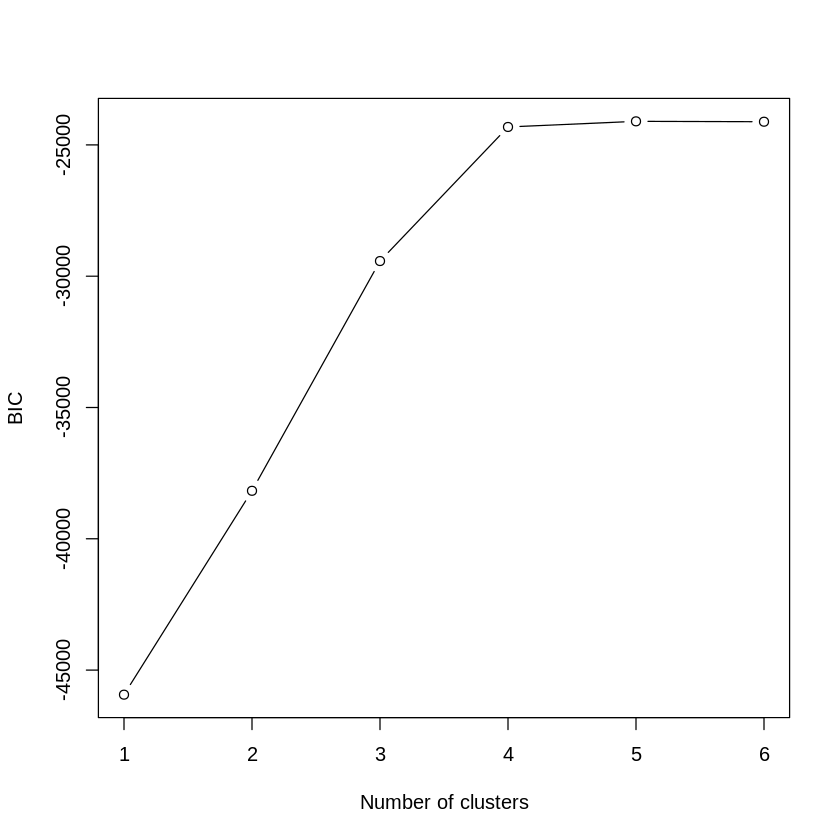

In [ ]:
varclust_res = mlcc.bic(X, numb.cores = 5, verbose=TRUE, max.iter=1, numb.runs=1,  numb.clusters = 1:10, show.warnings=TRUE)

Number of clusters 	 BIC 
        1          -45936 
        2          -34362 
        3          -29424 
        4          -24155 
        5          -23925 
        6          -24149 


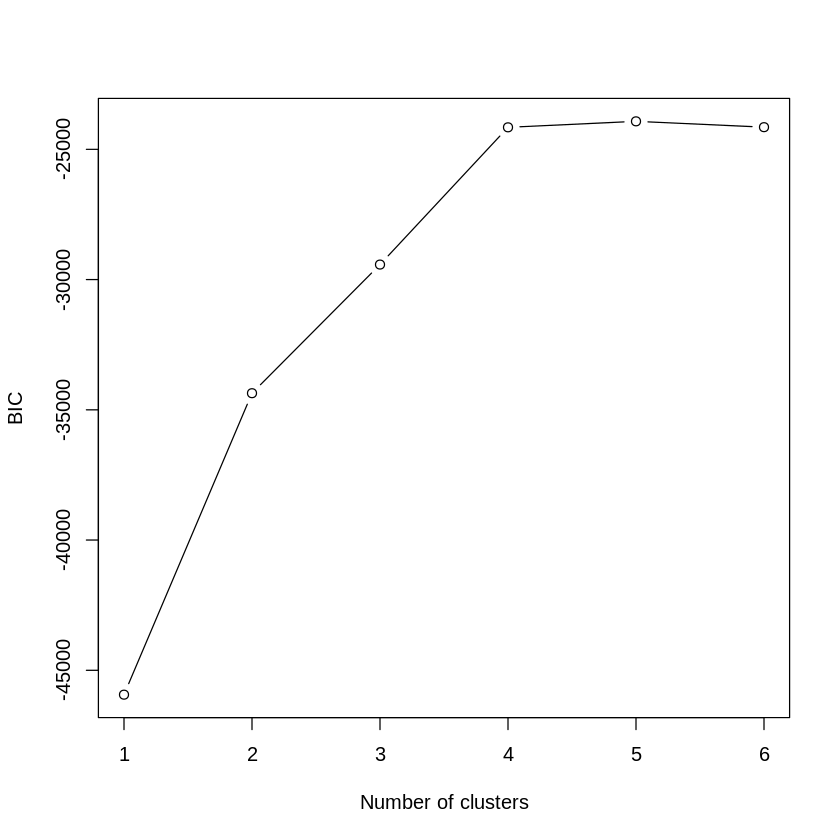

In [ ]:
#true number of clusters =4
varclust_res=mlcc.bic(X, numb.runs = 1, verbose=TRUE)

In [ ]:
varclust_res

$nClusters:  4 
$segmentation:
  [1] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [38] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [75] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[186] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[223] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[260] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[297] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[334] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[371] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4
[408] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[445] 4 4

In [ ]:
install.packages("mclust")
library(mclust)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Package 'mclust' version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



In [ ]:
library(mclust)

true_labels <- rep(1:4, each = 200)
estimated_clusters <- varclust_res$segmentation

ari <- adjustedRandIndex(true_labels, estimated_clusters)

# integration - dla każdego klastra sprawdzamy czy kolumny pochodzą z różnych prawdziwych grup
cluster_members <- split(true_labels, estimated_clusters)
integration <- mean(sapply(cluster_members, function(x) length(unique(x)) > 1))

# acontamination - udział elementów w klastrze spoza głównej grupy
cluster_sizes <- table(estimated_clusters)
acont <- mean(sapply(names(cluster_members), function(cl) {
  members <- cluster_members[[cl]]
  main_group_size <- max(table(members))
  contamination <- 1 - main_group_size / length(members)
  contamination
}))

list(
  nClusters = varclust_res$nClusters,
  subspacesDimensions = varclust_res$subspacesDimensions,
  BIC = varclust_res$BIC,
  ARI = ari,
  Integration = integration,
  Acontamination = acont
)


$nClusters
[1] 4

$subspacesDimensions
$subspacesDimensions[[1]]
[1] 3

$subspacesDimensions[[2]]
[1] 4

$subspacesDimensions[[3]]
[1] 3

$subspacesDimensions[[4]]
[1] 4


$BIC
[1] -23800.28

$ARI
[1] 0.9933418

$Integration
[1] 0.25

$Acontamination
[1] 0.002475248

2b)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Liczba wybranych głównych komponentów wg PESEL: 12 
MSE rekonstrukcji PCA: 0.1158324 
MSE rekonstrukcji SPCA: 0.9003644 

Top 10 zmiennych wg ładunków PCA dla każdej PC:
      PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10 PC11 PC12
 [1,] 756  37 223 685 735 213 158 167 744  140   41  453
 [2,] 710 160 342 799 560 228 177 417 506   41  128  391
 [3,] 647 147 343 688 632 358  95 606 408   29  389  541
 [4,] 709  96 310 727 650 252 106 736 628   54  140  413
 [5,] 662  51 372 706 677 334 137 776 546  113  113  434
 [6,] 762 184 231 703 738 355  21 432 702  109  391  546
 [7,] 699  14 308 739 734 275 155   5 573   82  331  656
 [8,] 750 114 294 781 668 290  30 635 444   62  301  523
 [9,] 618 157 224 729 686 360  43 197 629  607  377  558
[10,] 626  24 346 717 683 302 195 498 462  190   82  459

Top 10 zmiennych wg ładunków SPCA dla każdej PC:
      PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10 PC11 PC12
 [1,] 650 193 350 706 582 278  89 485 700  172  253  493
 [2,] 647 181 233 749 476 316  10 551 6

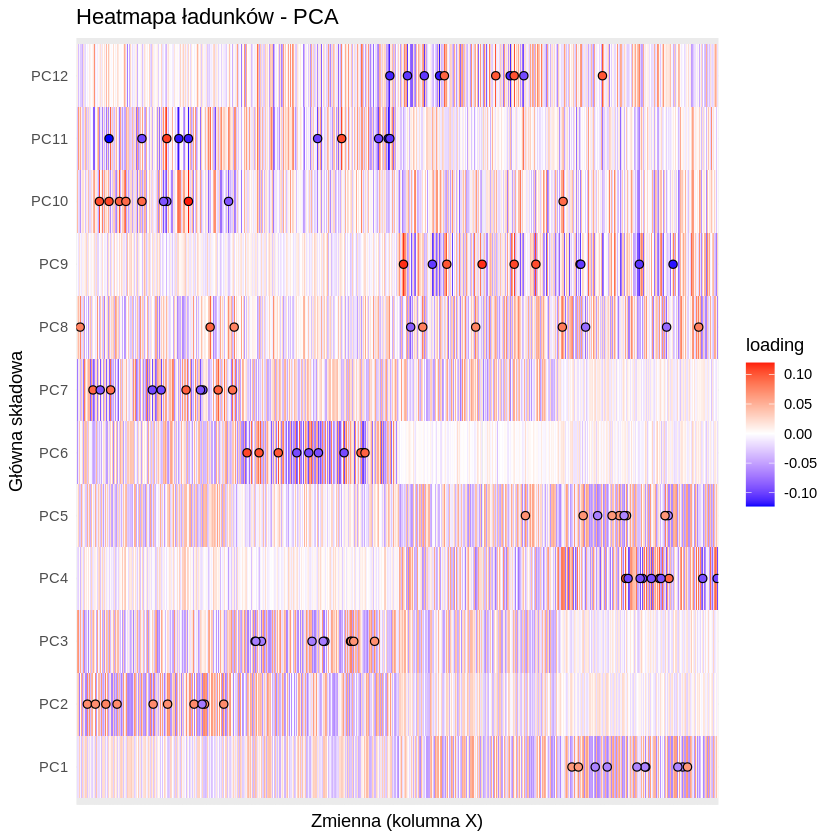

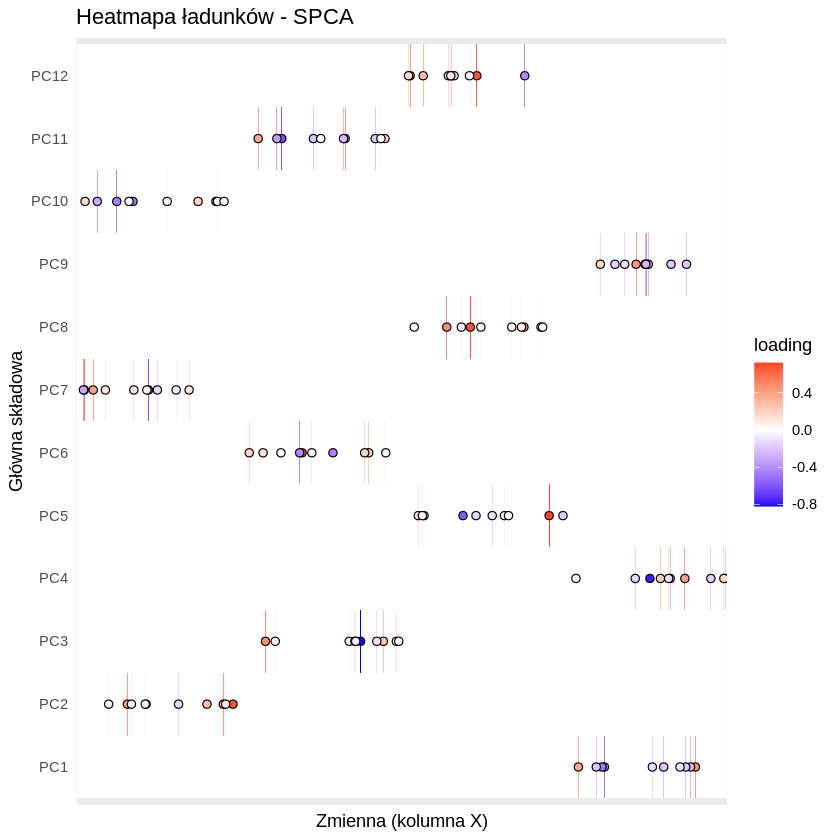

In [ ]:
install.packages("elasticnet")


library(pesel)
library(elasticnet)
library(ggplot2)
library(tidyr)
library(dplyr)


set.seed(123)
n <- 50
p <- 800
K <- 4
block_size <- p / K


X_blocks <- lapply(1:K, function(k) {
  Fi <- matrix(rnorm(n * 3), nrow = n, ncol = 3)
  Wi <- do.call(cbind, lapply(1:3, function(j) (4 - j) * rnorm(block_size)))
  Ei <- matrix(rnorm(n * block_size), nrow = n, ncol = block_size)
  Fi %*% t(Wi) + Ei
})

X <- do.call(cbind, X_blocks)

pesel_res <- pesel(X, npc.max = 20)
k_hat <- pesel_res$nPCs
cat("Liczba wybranych głównych komponentów wg PESEL:", k_hat, "\n")

pca_res <- prcomp(X, center = TRUE, scale. = TRUE, rank. = k_hat)
X_recon_pca <- pca_res$x %*% t(pca_res$rotation)
mse_pca <- mean((scale(X) - X_recon_pca)^2)
cat("MSE rekonstrukcji PCA:", mse_pca, "\n")


X_scaled <- scale(X)

X_scaled <- scale(X)
spca_res <- spca(X_scaled, K = k_hat, type = "predictor", sparse = "varnum", para = rep(10, k_hat))

Lsp   <- spca$loadings
Ssp   <- X_scaled %*% Lsp
Xrec_spca <- Ssp %*% t(Lsp)

mse_spca <- mean((X_scaled - Xrec_spca)^2)
cat("MSE rekonstrukcji SPCA:", mse_spca, "\n")

top_loadings_pca <- apply(abs(pca_res$rotation[, 1:k_hat]), 2, function(x) order(x, decreasing = TRUE)[1:10])
top_loadings_spca <- apply(abs(spca_res$loadings), 2, function(x) order(x, decreasing = TRUE)[1:10])

cat("\nTop 10 zmiennych wg ładunków PCA dla każdej PC:\n")
print(top_loadings_pca)

cat("\nTop 10 zmiennych wg ładunków SPCA dla każdej PC:\n")
print(top_loadings_spca)

plot_loadings <- function(loadings_mat, method_name) {
  loadings_df <- as.data.frame(loadings_mat)
  loadings_df$variable <- factor(1:p)
  loadings_long <- pivot_longer(loadings_df, cols = -variable, names_to = "PC", values_to = "loading")
  loadings_long$PC <- factor(loadings_long$PC, levels = colnames(loadings_mat))
  loadings_long$abs_loading <- abs(loadings_long$loading)

  top10 <- loadings_long %>% group_by(PC) %>% slice_max(abs_loading, n = 10)

  ggplot(loadings_long, aes(x = variable, y = PC, fill = loading)) +
    geom_tile() +
    scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
    geom_point(data = top10, aes(x = variable, y = PC), color = "black", size = 2, shape = 21) +
    labs(title = paste("Heatmapa ładunków -", method_name),
         x = "Zmienna (kolumna X)",
         y = "Główna składowa") +
    theme_minimal() +
    theme(axis.text.x = element_blank(),
          axis.ticks.x = element_blank())
}

plot_loadings(pca_res$rotation[, 1:k_hat], "PCA")
plot_loadings(spca_res$loadings, "SPCA")


In [4]:
install.packages("glasso")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
install.packages("Matrix")
library(Matrix)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [6]:
library(MASS)
library(glasso)

set.seed(123)

n <- 100
p <- 30
block_size <- 10
rho <- 0.7


make_block <- function(size, rho) {
  mat <- matrix(rho, size, size)
  diag(mat) <- 1
  return(mat)
}

Sigma <- bdiag(
  make_block(block_size, rho),
  make_block(block_size, rho),
  make_block(block_size, rho)
)
Sigma <- as.matrix(Sigma)
Theta_true <- solve(Sigma)


X <- mvrnorm(n, mu = rep(0, p), Sigma = Sigma)

S <- cov(X)
Theta_covinv <- tryCatch({
  solve(S)
}, error = function(e) {
  matrix(NA, p, p)
})

mse_covinv <- mean((Theta_covinv - Theta_true)^2, na.rm = TRUE)

# glasso z dopasowaniem lambda do najmniejszego MSE
lambdas <- seq(0.01, 0.3, length.out = 30)
mse_glasso <- numeric(length(lambdas))
glassos <- list()

for (i in seq_along(lambdas)) {
  glasso_fit <- glasso(S, rho = lambdas[i])
  Theta_hat <- glasso_fit$wi
  mse_glasso[i] <- mean((Theta_hat - Theta_true)^2)
  glassos[[i]] <- glasso_fit
}

best_idx <- which.min(mse_glasso)
Theta_best <- glassos[[best_idx]]$wi
best_lambda <- lambdas[best_idx]
best_mse <- mse_glasso[best_idx]


list(
  MSE_sample_inverse = mse_covinv,
  MSE_glasso = best_mse,
  best_lambda = best_lambda
)


$MSE_sample_inverse
[1] 0.4101762

$MSE_glasso
[1] 0.02227093

$best_lambda
[1] 0.04